In [ ]:
!pip show torch tensorflow

Name: torch
Version: 2.5.0+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision
---
Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl,

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [ ]:
dataset = MNIST(root="data/",download=True)

In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train

In [ ]:
test_ds = MNIST(root="data/",train=False)

In [ ]:
test_ds

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

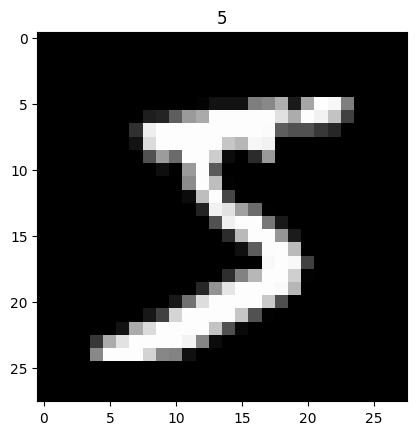

In [ ]:
image,label = dataset[0]
plt.figure()
plt.title(f"{label}")
plt.imshow(image,cmap='gray')

In [ ]:
import torchvision.transforms as transformer

In [ ]:
dataset = MNIST(root="data/",
                train=True,
                transform=transformer.ToTensor())

In [ ]:
img,label = dataset[0]
img.shape,label

(torch.Size([1, 28, 28]), 5)

In [ ]:
img[:,10:15,10:15]

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])

In [ ]:
torch.max(img),torch.min(img)

(tensor(1.), tensor(0.))

In [ ]:
from torch.utils.data import random_split

train_ds,val_ds = random_split(dataset,[50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size)

In [ ]:
train_loader

In [ ]:
import torch.nn as fnn

img_size = 28*28
classes = 10

model = fnn.Linear(img_size,classes)

In [ ]:
model.weight.shape

torch.Size([10, 784])

In [ ]:
class FNN(fnn.Module):
  def __init__(self):
    super().__init__()
    self.linear = fnn.Linear(img_size,classes)

  def forward(self,xb):
    xb = xb.reshape(-1,784)
    out = self.linear(xb)
    return out
model = FNN()

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0236, -0.0181,  0.0106,  ..., -0.0123, -0.0104, -0.0191],
         [-0.0053, -0.0111,  0.0011,  ...,  0.0070,  0.0199,  0.0218],
         [-0.0326, -0.0332,  0.0337,  ..., -0.0216, -0.0316,  0.0192],
         ...,
         [ 0.0304,  0.0174,  0.0147,  ..., -0.0189, -0.0186,  0.0093],
         [ 0.0170,  0.0290, -0.0179,  ...,  0.0063,  0.0014, -0.0334],
         [ 0.0236, -0.0079, -0.0301,  ..., -0.0305,  0.0276, -0.0086]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0257, -0.0225,  0.0196,  0.0232, -0.0008, -0.0215,  0.0321,  0.0138,
         -0.0227, -0.0185], requires_grad=True)]

In [ ]:
for imgs,labels in train_loader:
  outputs = model(imgs)
  break

In [ ]:
torch.exp(outputs[0]) / torch.sum(torch.exp(outputs[0]))

tensor([0.1164, 0.0918, 0.0768, 0.0974, 0.1278, 0.0904, 0.1239, 0.0914, 0.1095,
        0.0747], grad_fn=<DivBackward0>)

In [ ]:
import torch.nn.functional as F

In [ ]:
prob = F.softmax(outputs,dim=1)


In [ ]:
maxes,preds = torch.max(prob,dim=1)

In [ ]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
accuracy(outputs,labels)

tensor(0.0391)

In [ ]:
loss_fn = F.cross_entropy
loss = loss_fn(outputs,labels)

In [ ]:
loss

tensor(2.3787, grad_fn=<NllLossBackward0>)

In [ ]:
class FNN(fnn.Module):
  def __init__(self):
    super().__init__()
    self.linear = fnn.Linear(img_size,classes)

  def forward(self,xb):
    xb = xb.reshape(-1,784)
    out = self.linear(xb)
    return out

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_acc':acc,'val_loss':loss}

  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs ]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,res):
    print(f"Epoch {epoch},val_loss:{res['val_loss']},val_acc:{res['val_acc']}")
model = FNN()

In [ ]:
def eval(model,val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
def fit(epochs,lr,model,train_loader,val_loader,opt=torch.optim.SGD):
  history = []
  optimizer = opt(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = eval(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [ ]:
res = eval(model,val_loader)

In [ ]:
res

{'val_loss': 2.3248026371002197, 'val_acc': 0.09869462251663208}

In [ ]:
hist = fit(5,0.001,model,train_loader,val_loader)
hist

Epoch 0,val_loss:1.9616382122039795,val_acc:0.6157041192054749
Epoch 1,val_loss:1.6910977363586426,val_acc:0.7215189933776855
Epoch 2,val_loss:1.4888052940368652,val_acc:0.7556368708610535
Epoch 3,val_loss:1.3362276554107666,val_acc:0.7772942781448364
Epoch 4,val_loss:1.2190616130828857,val_acc:0.7881724834442139


[{'val_loss': 1.9616382122039795, 'val_acc': 0.6157041192054749},
 {'val_loss': 1.6910977363586426, 'val_acc': 0.7215189933776855},
 {'val_loss': 1.4888052940368652, 'val_acc': 0.7556368708610535},
 {'val_loss': 1.3362276554107666, 'val_acc': 0.7772942781448364},
 {'val_loss': 1.2190616130828857, 'val_acc': 0.7881724834442139}]

In [ ]:
hist2 = fit(5,0.001,model,train_loader,val_loader)
hist

Epoch 0,val_loss:1.1271207332611084,val_acc:0.7988528609275818
Epoch 1,val_loss:1.053421974182129,val_acc:0.8068631291389465
Epoch 2,val_loss:0.9931457042694092,val_acc:0.8121044039726257
Epoch 3,val_loss:0.9430163502693176,val_acc:0.8175435066223145
Epoch 4,val_loss:0.9006830453872681,val_acc:0.8230814933776855


[{'val_loss': 1.9616382122039795, 'val_acc': 0.6157041192054749},
 {'val_loss': 1.6910977363586426, 'val_acc': 0.7215189933776855},
 {'val_loss': 1.4888052940368652, 'val_acc': 0.7556368708610535},
 {'val_loss': 1.3362276554107666, 'val_acc': 0.7772942781448364},
 {'val_loss': 1.2190616130828857, 'val_acc': 0.7881724834442139}]

In [ ]:
hist3 = fit(5,0.001,model,train_loader,val_loader)
hist3

Epoch 0,val_loss:0.8644201755523682,val_acc:0.827531635761261
Epoch 1,val_loss:0.8330211639404297,val_acc:0.8307951092720032
Epoch 2,val_loss:0.8055475354194641,val_acc:0.8330696225166321
Epoch 3,val_loss:0.781283974647522,val_acc:0.8355419039726257
Epoch 4,val_loss:0.7596958875656128,val_acc:0.8378164768218994


[{'val_loss': 0.8644201755523682, 'val_acc': 0.827531635761261},
 {'val_loss': 0.8330211639404297, 'val_acc': 0.8307951092720032},
 {'val_loss': 0.8055475354194641, 'val_acc': 0.8330696225166321},
 {'val_loss': 0.781283974647522, 'val_acc': 0.8355419039726257},
 {'val_loss': 0.7596958875656128, 'val_acc': 0.8378164768218994}]

In [ ]:
hist4 = fit(5,0.001,model,train_loader,val_loader)
hist4

Epoch 0,val_loss:0.7403348684310913,val_acc:0.8404865264892578
Epoch 1,val_loss:0.7228690981864929,val_acc:0.8421677350997925
Epoch 2,val_loss:0.7070354223251343,val_acc:0.8440466523170471
Epoch 3,val_loss:0.6925988793373108,val_acc:0.8451344966888428
Epoch 4,val_loss:0.6793643832206726,val_acc:0.8472112417221069


[{'val_loss': 0.7403348684310913, 'val_acc': 0.8404865264892578},
 {'val_loss': 0.7228690981864929, 'val_acc': 0.8421677350997925},
 {'val_loss': 0.7070354223251343, 'val_acc': 0.8440466523170471},
 {'val_loss': 0.6925988793373108, 'val_acc': 0.8451344966888428},
 {'val_loss': 0.6793643832206726, 'val_acc': 0.8472112417221069}]

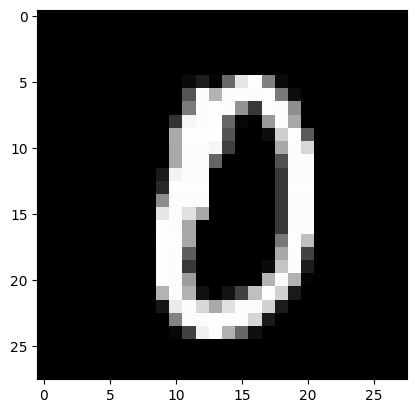

In [ ]:
img,label = test_ds[55]
x = transformer.ToTensor()
img = x(img)
plt.imshow(img[0],cmap='gray')

In [ ]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [ ]:
def predict(img,model):
  #plt.imshow(img[0],cmap='gray')
  xb = img[0].unsqueeze(0)
  yb = model(xb)
  _,preds = torch.max(yb,dim=1)
  return preds[0].item()

In [ ]:
predict(img,model)

7

In [ ]:
test_ds = MNIST(root='data/',train=False,transform=transformer.ToTensor())

In [ ]:
corr_preds = 0
total = 0
for img,label in test_ds:
  pred = predict(img,model)
  if pred == label:
    corr_preds += 1
  total += 1

In [ ]:
acc corr_preds/total

0.8619